# Image Classification

### [2023.12.18] 이상혁

### 개요
- Tensorflow Dataset에 있는 EuroSAT 데이터를 활용한 Image Classification 모델을 만들어보고자 한다.
- EuroSAT 데이터셋 : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 데이터셋

### 0. GPU Configuration

💻빠른 연산을 위해 Tensorflow에서 **GPU**를 사용할 수 있도록 설정해준다.

In [1]:
# gpu 사용 가능 여부 확인
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 0번째 디바이스 사용
gpus = tf.config.experimental.list_physical_devices('GPU') # GPU 장치 목록 반환

if gpus:
    try: 
        tf.config.experimental.set_memory_growth(gpus[0], True) # gpu가 있다면 활성화 시킨다.
    except RuntimeError as e: 
        print(e)

GPU 설정이 마무리 되었다. 이제 본격적으로 Image Classification을 위한 데이터부터 불러오자.

### 1. Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds # 텐서플로우 데이터셋

import PIL # 이미지 분석 라이브러리
import pathlib # 파일위치 찾기, 파일 입출력과 같은 동작
import glob # 파일명 및 확장자를 다루는 라이브러리

from tensorflow.keras.applications import ResNet50 # ResNet
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16

from tensorflow.keras.callbacks import EarlyStopping # 조기종료

그리고 결과의 재구현을 위해 **랜덤 시드**도 고정해준다.

In [4]:
# 시드 설정
SEED = 1218

random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 2. Load Data

In [5]:
# Train, Validation, Test를 나눠서 불러온다
splits=('train[:70%]','train[70%:90%]', 'train[90%:]')

# 데이터 불러오기
(train, val, test), metadata = tfds.load(name='eurosat',
                                         as_supervised=True, # (Input, Label) 형태로 불러오기
                                         split=splits, # 데이터 Split을 지정
                                         with_info=True) # 데이터 Info도 같이 불러오기

In [6]:
# 라벨링 데이터 저장
get_label_name = metadata.features['label'].int2str

### 3. Data Pre-processing

이미지 데이터는 데이터의 양이 한정되어 있다. 따라서 다양한 기법을 활용해서 이미지 데이터를 변형해서 모델을 학습시킨다. 이를 **데이터 증강(Data Augmentation)**이라고 한다. <br>
이를 통해서 모델의 성능을 높이고 오버피팅을 극복할 수 있다😎 아래 그림은 데이터 증강의 예시이다.

![image1](C:/Python_Programs/Tensorflow/image1.png) 

이미지 데이터 증강에 대한 내용은 아래의 블로그에서 잘 정리해뒀다! 나중에 직접 해보자. <br>
[이미지 증강 - 티스토리](https://lcyking.tistory.com/77 '구글')

In [7]:
# 이미지 증강을 위한 하이퍼파라미터 정의
batch_size = 32 # 가중치를 한번 업데이트시킬 때 사용되는 샘플들의 수
epochs = 10 # 학습의 횟수
img_height = 64 # 이미지 크기
img_width = 64 # 이미지 크기
AUTOTUNE = tf.data.experimental.AUTOTUNE # 사용 가능한 CPU를 동적으로 설정

In [8]:
# 이미지 크기 변경
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32) # 데이터 타입 변환 이미지(Int) -> 텐서(Tensor)
    image = tf.image.resize(image, [img_height, img_width]) # 이미지 크기 리사이즈
    image = (image / 255.0) # 정규화
    return image, label

In [9]:
def augment(image,label):
    image, label = resize_and_rescale(image, label)
    
    # 90도 단위로 랜덤 회전
    rand_rotation = random.randint(0, 3)
    image = tf.image.rot90(image, k=rand_rotation)
    
    # 랜덤한 크기로 이미지 확대 후 원본 크기로 잘라냄
    image = tf.image.random_crop(image, size=[img_height, img_width, 3]) # Random crop back to the original size
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.5)  # 최대 밝기 변경 값 설정
    
    # 노이즈 생성
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1.0, dtype=tf.float32)
    noise_factor = 0.3
    noisy_image = tf.clip_by_value(image + noise * noise_factor, clip_value_min=0.0, clip_value_max=1.0)
    
    return image, label

데이터 증강에 대한 함수를 정의했으니, 이제 Train, Validation, Test 데이터에 데이터 증강을 적용하자!

In [10]:
train = (
    train
    .shuffle(1000) # 트레이닝 시 1000개 단위로 셔플
    .map(augment, num_parallel_calls=AUTOTUNE) # 위에서 정의한 데이터 증강을 적용
    .batch(batch_size) # 배치사이즈
    .prefetch(AUTOTUNE) # S 스텝을 훈련하는 동안 S+1 스텝의 데이터를 미리 가져옴
)

In [11]:
val = (
    val
    .map(augment, num_parallel_calls=AUTOTUNE) # 위에서 정의한 데이터 증강을 적용
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [12]:
test = (
    test
    .map(augment, num_parallel_calls=AUTOTUNE) # 위에서 정의한 데이터 증강을 적용
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

### 4. Modelling

#### 4-1. Basic CNN Model

첫번째 모델은 간단한 CNN 함수를 만들어보자. 층은 다음과 같이 구성했다.
- 첫번째 은닉층 : 뉴런 32개, 커널 사이즈 3 -> ReLU(활성화 함수) -> 맥스 풀링
- 두번째 은닉층 : 뉴런 64개, 커널 사이즈 3 -> ReLU(활성화 함수) -> 맥스 풀링
- 마지막 전결합 층 : 평탄화 -> 뉴런 256개 -> ReLU(활성화 함수) -> 뉴런 10개 -> Softmax(활성화 함수)

ReLU 함수를 지나 CNN 모델이 처리하는 Feature Map의 크기를 줄이기 위해 맥스 풀링(Max Pooling)을 사용했다. 그리고 마지막 전결합층에서는 1차원 배열로 평탄화를 진행하고 10개의 이미지로 분류하기 위해 활성화 함수로 Softmax 함수를 사용한다.

In [13]:
# 입력 크기
input_shape = (img_height, img_width, 3)

In [14]:
# 라벨 개수 지정
num_classes = 10

In [16]:
basic_cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
basic_cnn_model.build((None, 64, 64, 3))
basic_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

- 추정해야할 Parameter는 총 3,233,482개다.

이제 모델을 학습시키기 위해 Optimizer, Loss 함수, 평가 지표를 정의하고 모델을 Compile한다.

In [18]:
# Model Compile
basic_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [15]:
# 학습 과정을 확인하기 위한 Tensorboard
log_dir = "logs" + datetime.datetime.now().strftime("/%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
# 모델 Training
history1 = basic_cnn_model.fit(
    train, # 입력
    batch_size=batch_size, # 배치 사이즈
    validation_data=val, # Validation
    epochs=epochs, # 훈련 횟수
    callbacks=[tensorboard_callback]
)

Epoch 1/10
591/591 [==============================] - 32s 45ms/step - loss: 1.3112 - accuracy: 0.4969 - val_loss: 1.0051 - val_accuracy: 0.6239
Epoch 2/10
591/591 [==============================] - 26s 44ms/step - loss: 0.9064 - accuracy: 0.6680 - val_loss: 0.8573 - val_accuracy: 0.6881
Epoch 3/10
591/591 [==============================] - 27s 45ms/step - loss: 0.7736 - accuracy: 0.7192 - val_loss: 0.8154 - val_accuracy: 0.7135
Epoch 4/10
591/591 [==============================] - 26s 44ms/step - loss: 0.7058 - accuracy: 0.7476 - val_loss: 0.6570 - val_accuracy: 0.7654
Epoch 5/10
591/591 [==============================] - 26s 43ms/step - loss: 0.6076 - accuracy: 0.7856 - val_loss: 0.6135 - val_accuracy: 0.7813
Epoch 6/10
591/591 [==============================] - 24s 41ms/step - loss: 0.5537 - accuracy: 0.8040 - val_loss: 0.5676 - val_accuracy: 0.7963
Epoch 7/10
591/591 [==============================] - 26s 45ms/step - loss: 0.4979 - accuracy: 0.8249 - val_loss: 0.6872 - val_accuracy:

In [21]:
# Test Data로 Model 평가
basic_cnn_model.evaluate(test)

85/85 [==============================] - 2s 23ms/step - loss: 0.6612 - accuracy: 0.7619


[0.6612233519554138, 0.7618518471717834]

간단한 CNN 모델이지만 Accuracy가 약 76% 정도 나오고 있다. 활성화 함수, 뉴런 수, 층의 개수를 추가하면서 성능을 향상시킬 수 있을 것이다. <br>
모델의 학습 과정이 어땠는지 간단한 Plot을 그려보자.

In [16]:
# 학습 과정 시각화 함수
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

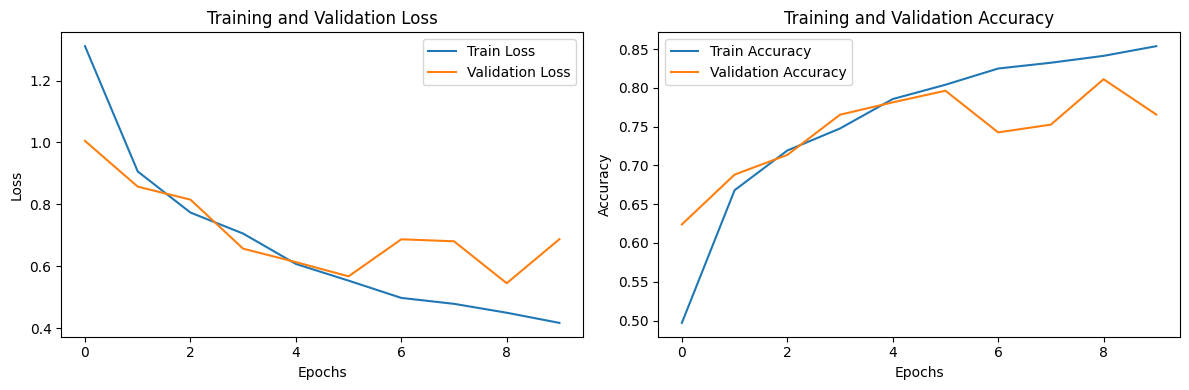

In [24]:
plot_training_history(history1)

항상 알 수 있는거지만, Train의 loss와 accuracy는 계속 증가하는 것이 당연하다. Epoch이 5 이후부터는 Validation의 변동이 생각보다 크다. 따라서 Epoch을 증가해서 모델을 학습시켜 볼 필요가 있겠다.

#### 4-2. Second CNN Model

첫 번째 모델의 성능이 괜찮았기 때문에, 여기서 약간의 수정을 거쳐서 성능을 향상시켜보고자 한다.
- 활성화 함수는 ReLU가 아닌 Leaky ReLU를 사용
    - ReLU 함수는 음수 영역에서 기울기 소실 문제가 발생한다. 이를 약간 개선 시키기 위해 Leaky ReLU 함수를 시도해본다.
- 배치 정규화 추가
- 은닉층의 개수를 2개에서 3개로 변경

In [17]:
second_cnn_model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=input_shape), # 아래 .build에서 Input에 대해서 정의하기 때문에 굳이 없어도 됨
    tf.keras.layers.Conv2D(filters=32, kernel_size=3),
    tf.keras.layers.LeakyReLU(alpha=0.1), # LeakyReLU 레이어 사용
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3),
    tf.keras.layers.LeakyReLU(alpha=0.1), # LeakyReLU 레이어 사용
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3), # 3번째 은닉층 추가
    tf.keras.layers.LeakyReLU(alpha=0.1), # LeakyReLU 레이어 사용
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
second_cnn_model.build((None, 64, 64, 3))
second_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 29, 29, 64)        0

In [19]:
# Model Compile
second_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [20]:
# 모델 Training
history2 = second_cnn_model.fit(
    train, # 입력
    batch_size=batch_size, # 배치 사이즈
    validation_data=val, # Validation
    epochs=epochs, # 훈련 횟수
    callbacks=[tensorboard_callback]
)

Epoch 1/10
591/591 [==============================] - 37s 52ms/step - loss: 1.1631 - accuracy: 0.5735 - val_loss: 1.0474 - val_accuracy: 0.6463
Epoch 2/10
591/591 [==============================] - 24s 41ms/step - loss: 0.7983 - accuracy: 0.7122 - val_loss: 0.8311 - val_accuracy: 0.7176
Epoch 3/10
591/591 [==============================] - 31s 52ms/step - loss: 0.6466 - accuracy: 0.7723 - val_loss: 0.6599 - val_accuracy: 0.7669
Epoch 4/10
591/591 [==============================] - 33s 56ms/step - loss: 0.5423 - accuracy: 0.8100 - val_loss: 0.6719 - val_accuracy: 0.7657
Epoch 5/10
591/591 [==============================] - 34s 57ms/step - loss: 0.4665 - accuracy: 0.8386 - val_loss: 0.7717 - val_accuracy: 0.7480
Epoch 6/10
591/591 [==============================] - 28s 47ms/step - loss: 0.4129 - accuracy: 0.8603 - val_loss: 0.5509 - val_accuracy: 0.8054
Epoch 7/10
591/591 [==============================] - 28s 47ms/step - loss: 0.3816 - accuracy: 0.8654 - val_loss: 0.5029 - val_accuracy:

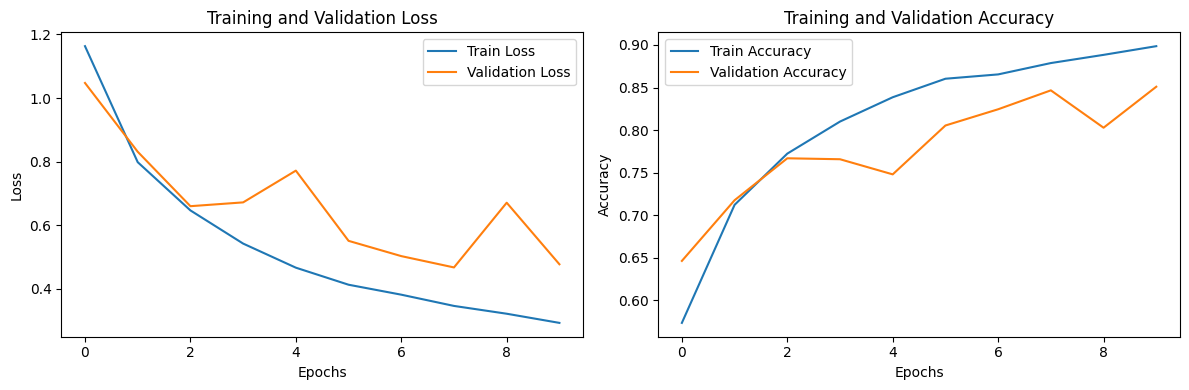

In [21]:
plot_training_history(history2)

모델 학습은 이전처럼 잘 되고 있다. 그리고 모델 검증도 epoch이 진행됨에 따라 큰 변동 없이 지속적인 모습을 보여준다.

In [22]:
# Test Data로 Model 평가
second_cnn_model.evaluate(test)

85/85 [==============================] - 2s 21ms/step - loss: 0.5188 - accuracy: 0.8470


[0.5188224911689758, 0.8470370173454285]

모델 평가 결과 정확도는 이전과 비슷한 84%로 나오고 있다. 층이 많으면 성능이 좋은 것을 확인할 수 있다. 물론 단순하게 층을 많이 쌓는다고 딥러닝 모델의 성능이 좋지는 않다. 적절한 하이퍼파라미터를 설정하고 데이터를 손 보는 것이 더 중요할 것이다. 그리고 CNN 모델이 아닌 다른 이미지 처리 모델도 시도해볼 필요가 있다.

#### 4-3 ResNet50 Model

ResNet은 Residual CNN 모델이다. 기존 모델들은 손실함수를 통해 예측값과 실제값의 차이를 줄이면서 학습을 진행했다면, ResNet은 기존 값에 잔차를 더하면서 학습을 진행한다. 이 과정을 통해서 이미지의 노이즈를 더 잘 잡아내는 모델이다. 이번에는 ResNet을 통해서 딥러닝 모델의 성능을 높여보겠다.

가장 먼저 사용해볼 모델은 **ResNet50**이다. 해당 모델은 50개의 은닉층이 있어서 ResNet50이라고 부른다.

In [38]:
basic_resnet_model = tf.keras.applications.ResNet50(
    include_top = False, # include_top 옵션을 false로 설정해서 top 레이어를 제거
    weights = None, # 'imagenet'을 사용하기 위해선 classes가 1000이어야 한다고 한다. 그래서 None으로 설정했다.
    input_shape = input_shape,
    pooling = max, # Max Pooling 사용 
    classes = num_classes
)

In [39]:
basic_resnet_model.build((None, 64, 64, 3))
basic_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

추정해야할 파라미터 개수가 정말 많다😅

In [40]:
# Model Compile
basic_resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [41]:
# 모델 Training
history3 = basic_resnet_model.fit(
    train, # 입력
    batch_size=batch_size, # 배치 사이즈
    validation_data=val, # Validation
    epochs=epochs, # 훈련 횟수
    callbacks=[tensorboard_callback]
)

Epoch 1/10
591/591 [==============================] - 216s 349ms/step - loss: 2.0795 - accuracy: 0.3388 - val_loss: 15.4287 - val_accuracy: 0.2009
Epoch 2/10
591/591 [==============================] - 210s 355ms/step - loss: 1.4021 - accuracy: 0.5069 - val_loss: 1.9080 - val_accuracy: 0.4739
Epoch 3/10
591/591 [==============================] - 198s 336ms/step - loss: 1.1541 - accuracy: 0.5883 - val_loss: 4.8051 - val_accuracy: 0.2354
Epoch 4/10
591/591 [==============================] - 193s 327ms/step - loss: 1.0885 - accuracy: 0.6118 - val_loss: 22.0845 - val_accuracy: 0.3102
Epoch 5/10
591/591 [==============================] - 200s 339ms/step - loss: 1.0693 - accuracy: 0.6220 - val_loss: 3.7181 - val_accuracy: 0.4735
Epoch 6/10
591/591 [==============================] - 201s 339ms/step - loss: 1.1355 - accuracy: 0.6107 - val_loss: 1.8462 - val_accuracy: 0.4285
Epoch 7/10
591/591 [==============================] - 209s 353ms/step - loss: 1.0077 - accuracy: 0.6463 - val_loss: 0.9611

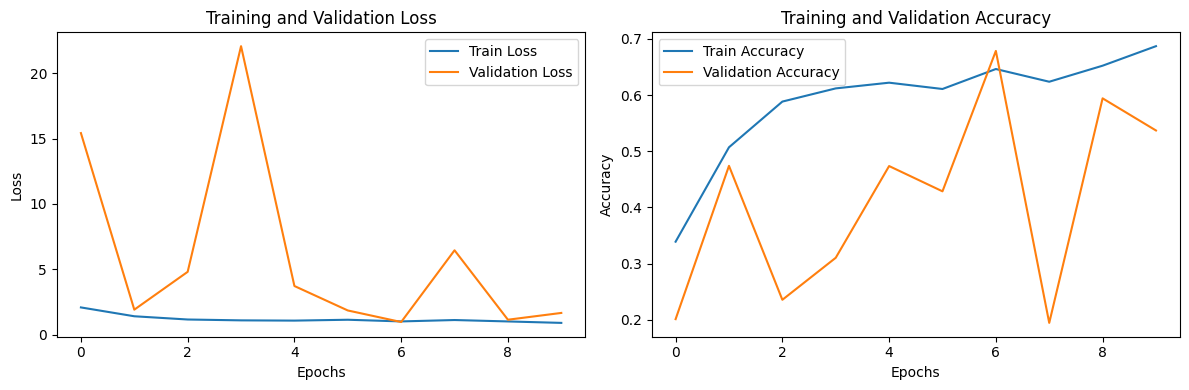

In [42]:
plot_training_history(history3)

In [43]:
# Test Data로 Model 평가
basic_resnet_model.evaluate(test)

85/85 [==============================] - 9s 109ms/step - loss: 1.4466 - accuracy: 0.5315


[1.446589469909668, 0.5314815044403076]

모델 평가 결과 정확도가 53%로 기본적인 CNN 모델보다 안 좋은 성능을 보여준다...😥 학습 과정 Plot을 확인해봐도 그 과정이 매우 임의적인거 같다. epoch 수가 10 이어서 정확한 학습 과정을 알기는 어렵지만 그래도 성능은 좋지 않다고 생각한다.

#### 4-4. VGG Model

이번에는 사전학습된 VGG16 Model을 통해서 성능을 높여보고자 한다. 다음을 추가하였다.
- 사전 훈련된 VGG16 모델
- 각 은닉층마다 합성곱층 + 합성곱층 + 맥스풀링 + (합성곱층에 스트라이드와 패딩을 추가)
- 전결합층
- Early Stopping

In [62]:
# Early Stopping 정의 : Validation Loss를 기준으로 3번 동안 개선이 없으면 종료
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [63]:
# 모델 정의
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [64]:
# 모델 Layer 사전 형태로 정의
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output

# CNN Layer + LeakyReLU(활성화 함수)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

# Max Pooling Layer
if x.shape[1] >= 2 and x.shape[2] >= 2:
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten Layer
x = tf.keras.layers.Flatten()(x) # 합성곱층 이후에는 평탄화를 해줘야 함

# 전결합 Layer
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # 최종 prediction

# vgg model 정의
vgg_model = tf.keras.models.Model(inputs = base_model.input, outputs = x)

In [65]:
vgg_model.build((None, 64, 64, 3))
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [66]:
# 모델 컴파일
vgg_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

In [67]:
# 모델 학습
history4 = vgg_model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/20
591/591 [==============================] - 225s 378ms/step - loss: 1.5996 - accuracy: 0.3702 - val_loss: 1.5237 - val_accuracy: 0.3346
Epoch 2/20
591/591 [==============================] - 217s 367ms/step - loss: 1.4768 - accuracy: 0.4240 - val_loss: 1.3056 - val_accuracy: 0.4930
Epoch 3/20
591/591 [==============================] - 217s 367ms/step - loss: 1.2065 - accuracy: 0.5422 - val_loss: 1.0241 - val_accuracy: 0.6035
Epoch 4/20
591/591 [==============================] - 227s 384ms/step - loss: 1.0133 - accuracy: 0.6202 - val_loss: 1.0343 - val_accuracy: 0.6172
Epoch 5/20
591/591 [==============================] - 224s 379ms/step - loss: 0.9586 - accuracy: 0.6440 - val_loss: 1.0037 - val_accuracy: 0.6087
Epoch 6/20
591/591 [==============================] - 229s 388ms/step - loss: 0.8080 - accuracy: 0.6993 - val_loss: 0.7252 - val_accuracy: 0.7274
Epoch 7/20
591/591 [==============================] - 214s 362ms/step - loss: 0.7613 - accuracy: 0.7175 - val_loss: 0.6928 -

조기종료 조건을 만족해서 epoch 11에서 학습이 종료되었다.

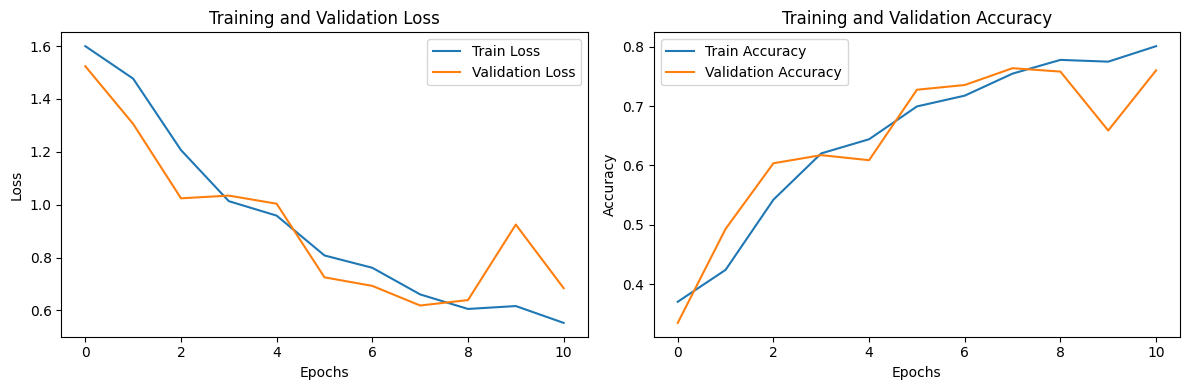

In [68]:
plot_training_history(history4)

Train과 Validation의 학습 양상이 매우 비슷하다. Plot만 눈으로 봤을 때는 학습이 굉장히 잘 된거 같다. Colab으로 돌리면서 early stopping 단계를 5로 늘리고 해보는거도 좋은 방법일거 같다.

In [69]:
# 테스트 데이터셋으로 평가
vgg_model.evaluate(test)

85/85 [==============================] - 13s 148ms/step - loss: 0.5772 - accuracy: 0.7900


[0.5771646499633789, 0.7900000214576721]

모델의 성능은 79%로 CNN, ResNet보다 개선되었다. 하지만 CNN에 비해 학습시간은 매우 오래 걸리는데 3% 정도의 개선이라 유의미하지는 않다고 생각한다.

#### 4-5. VGG Model 2

이번에는 친구가 시도한 VGG 모델이 성능이 잘 나온다고 해서 해당 모델을 사용해보도록 하겠다.

In [72]:
# 조기 종료 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# VGG16 마지막 4번째 층 전까지는 학습하지 않고 사전 훈련된 가중치를 사용
for layer in base_model.layers[:-4]: 
    layer.trainable = False

# VGG16 모델에 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Reshape((16, 16, 1))(x)  # 임의의 4D 사이즈로 reshape
x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.AveragePooling2D()(x)  # AveragePooling

x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.AveragePooling2D()(x)  # AveragePooling

x = tf.keras.layers.Flatten()(x)  # Convolutional 레이어 이후에는 Flatten

x = tf.keras.layers.Dense(10, activation='softmax')(x)

# 새로운 모델 정의
new_vgg_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

In [76]:
# 모델 컴파일
new_vgg_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [77]:
# 모델 학습
history5 = new_vgg_model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/20
591/591 [==============================] - 118s 198ms/step - loss: 0.7504 - accuracy: 0.7392 - val_loss: 0.4811 - val_accuracy: 0.8452
Epoch 2/20
591/591 [==============================] - 113s 192ms/step - loss: 0.4075 - accuracy: 0.8714 - val_loss: 0.4330 - val_accuracy: 0.8580
Epoch 3/20
591/591 [==============================] - 110s 186ms/step - loss: 0.3439 - accuracy: 0.8881 - val_loss: 0.3473 - val_accuracy: 0.8956
Epoch 4/20
591/591 [==============================] - 113s 191ms/step - loss: 0.3041 - accuracy: 0.9026 - val_loss: 0.3381 - val_accuracy: 0.8944
Epoch 5/20
591/591 [==============================] - 109s 185ms/step - loss: 0.2815 - accuracy: 0.9126 - val_loss: 0.3290 - val_accuracy: 0.9000
Epoch 6/20
591/591 [==============================] - 110s 186ms/step - loss: 0.2583 - accuracy: 0.9174 - val_loss: 0.2928 - val_accuracy: 0.9120
Epoch 7/20
591/591 [==============================] - 106s 180ms/step - loss: 0.2476 - accuracy: 0.9206 - val_loss: 0.3674 -

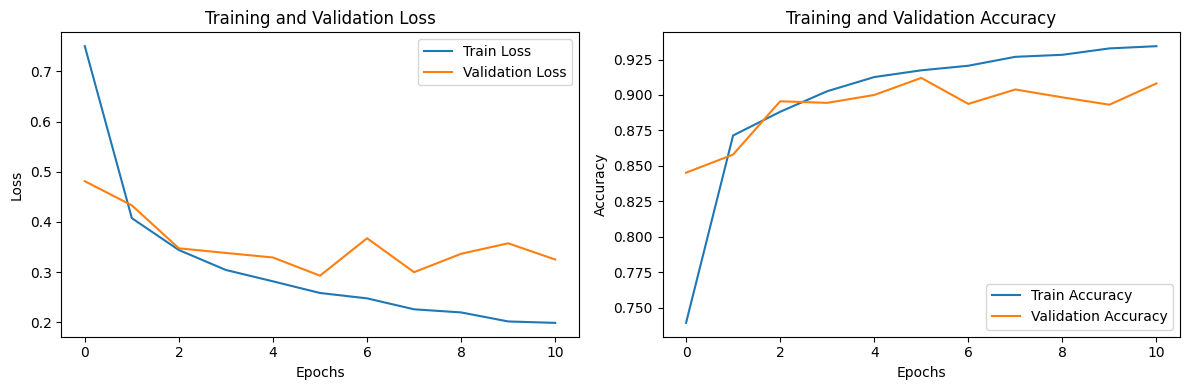

In [78]:
plot_training_history(history5)

epoch이 11에서 조기 종료 조건이 만족해서 학습을 종료했다. 사전 학습한 가중치를 사용했더니 학습 시간도 이전보다 훨씬 개선되었다. 과대적합 양상은 크게 보이지 않다.

In [79]:
# 테스트 데이터셋으로 평가
new_vgg_model.evaluate(test)

85/85 [==============================] - 11s 128ms/step - loss: 0.2646 - accuracy: 0.9163


[0.2646024227142334, 0.9162963032722473]

이전에는 70프로 후반대의 Accuracy 성능이 측정되었다. 이번 VGG 모델은 직접 훈련시키지 않고 사전 학습된 가중치를 사용했다. 그리고 새로 추가한 층의 가중치만을 학습하도록 해서 성능을 측정하니 91%의 Accuracy를 기록했다. 엄청난 성능 향상이다. 사전 가중치를 사용하면서 모델의 성능을 개선해보는 작업이 중요할 것 같다.

### 5. Conclusion

가장 성능이 좋았던 **사전 학습 가중치를 사용한 VGG** 모델의 결과를 살펴보자. 첫번째 Test 데이터의 이미지를 시각화해서 모델의 결과를 살펴보자.

In [81]:
for test_images, test_labels in test.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = new_vgg_model.predict(test_images)

1/1 [==============================] - 0s 209ms/step


In [82]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(images[i,], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(get_label_name(predicted_label),
                                       100*np.max(predictions_array),
                                       get_label_name(true_label)),
                                       color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

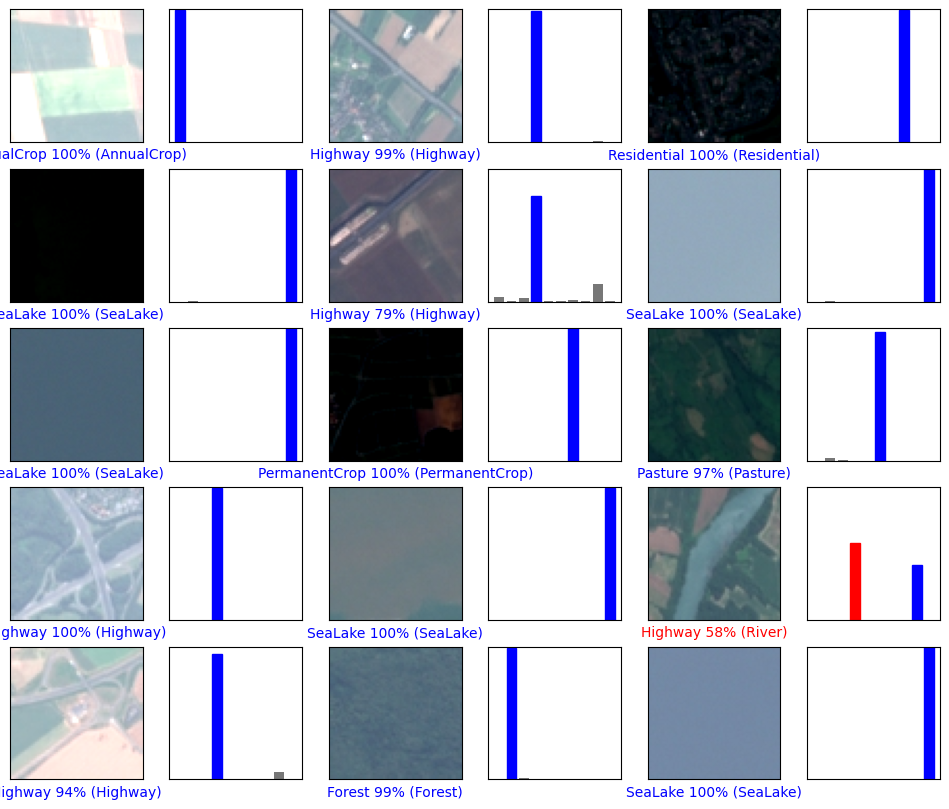

In [87]:
# 예측 label과 정답 label을 비교
# Correct predictions은 blue로, incorrect predictions은 red으로 표시
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

실제 정답은 River이지만 58%의 확률로 Highway로 예측하고 있다. 해당 이미지만 오분류하고 있고 다른 이미지는 잘 분류하고 있다.